# Analysis of Stock Market Investment Strategies

Author: Charles Lee

This Notebook aims to compare three different investment strategies using historical stock market data.
1. **Timing the Market (Ideal)** - Buying shares when shares are lowest every year
2. **Take Action (Now)** - Buying shares with all their money at the beginning of every year
3. **Dollar Cost Averaging (Average)** - Dividing up the money to buy shares at the beginning of every month

We will also see how these strategies fare against a random investor as our base scenario.

4. **Newbie (Random)** - Buys random amounts of stocks at random times.

Finally, we will take a look at "worst- and best-case scenarios" of investments.

5. **Unlucky (Worst)** - Saved up all their money and bought all right **before** the 2008 Stock Market Crash and 2020 COVID-19 Pandemic
6. **Omniscient (Perfect)** - Saved up all their money and bought all right **after** the 2008 Stock Market Crash and 2020 COVID-19 Pandemic

In all of these investment strategies, we are assuming that our investors will hold onto their stocks and not sell.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime
import calendar

sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

## Case Study of VTI
VTI is a highly popular ETF that holds shares from the top companies in America. Many people choose this as their choice of investment, so we will take a look at this in particular.

In [2]:
vti = pd.read_csv('vti.csv').sort_values('Date').reset_index(drop=True)
vti

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-06-15,55.424999,56.005001,55.174999,55.665001,38.659378,1067400
1,2001-06-18,55.814999,55.915001,55.310001,55.310001,38.412834,282600
2,2001-06-19,56.150002,56.165001,55.235001,55.465000,38.520493,1777600
3,2001-06-20,55.375000,56.075001,55.375000,56.049999,38.926777,476000
4,2001-06-21,56.000000,56.724998,55.875000,56.500000,39.239285,240400
...,...,...,...,...,...,...,...
4943,2021-02-09,205.600006,206.449997,205.250000,206.020004,206.020004,3384800
4944,2021-02-10,207.070007,207.220001,204.449997,205.929993,205.929993,3682400
4945,2021-02-11,206.699997,206.940002,204.820007,206.419998,206.419998,2630000
4946,2021-02-12,205.889999,207.509995,205.800003,207.490005,207.490005,2415000


In [3]:
vti_div = pd.read_csv('vti_Dividends.csv').sort_values('Date').reset_index(drop=True)
vti_div

,Date,Dividends
0,2001-06-25,0.1400
1,2001-09-24,0.1575
2,2001-12-24,0.1965
3,2002-03-25,0.1500
4,2002-06-24,0.1300
...,...,...
74,2019-12-24,0.8860
75,2020-03-26,0.6140
76,2020-06-25,0.7000
77,2020-09-25,0.6740


In [4]:
# Converting strings to datetime objects to make easier to work with
standardize_date = lambda string: datetime.datetime.strptime(string, '%Y-%m-%d')
vti['Date'] = vti['Date'].apply(standardize_date)
vti_div['Date'] = vti_div['Date'].apply(standardize_date)

### Here is a graph of VTI's stock price per day since 2001

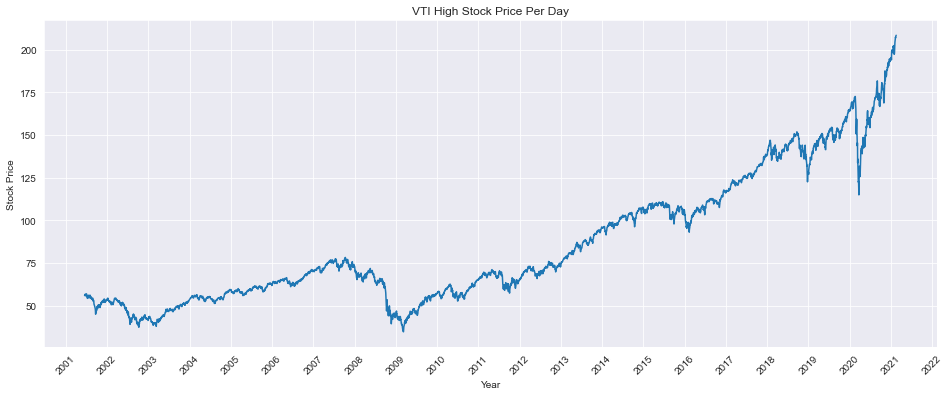

In [5]:
plt.figure(figsize=(16, 6))
g = sns.lineplot(x='Date', y='High', data=vti, ci=None)
plt.xticks([datetime.datetime(year=x, month=1, day=1) for x in range(2001, 2023)], rotation=45)
g.set_xticklabels(list(range(2001, 2023)))
g.set_xlabel('Year')
g.set_ylabel('Stock Price')
g.set_title('VTI High Stock Price Per Day');

### We define our Investors where each subclass executes their own strategy

In [6]:
class Investor():
    def __init__(self, stock, stock_div):
        # Creates portfolio and binds a stock
        self.portfolio = pd.DataFrame(columns=['Date', 'Purchase Price'])
        self.salary = 6000
        self.cash = 0
        self.stock = stock
        self.stock_div = stock_div
        self.profits = pd.DataFrame(columns=['Date', 'Profits'])
        self.first_date = self.stock['Date'][0]
        self.last_date = self.stock['Date'][len(vti)-1]
        self.dividends = pd.DataFrame(columns=['Date', 'Dividend Disbursement', 'Total Dividends'])
        
    def income(self):
        # Yearly disbursement of money
        self.cash += self.salary
    
    def create_date(self, string):
        # Transforms date string to datetime object
        if isinstance(string, str):
            return standardize_date(string)
        else:
            return string
    
    def get_nearest_date(self, date, reverse = False):
        # Gets the next closest date of the stock market being open and returns the row of data
        # Reverse false if we want the nearest next date. Reverse true if we want the nearest previous date
        date = self.create_date(date)
        if reverse:
            move = -1
        else:
            move = 1
        # Changes date until found market data, unless passed the first or last date
        while len(self.stock[self.stock['Date'] == date]) < 1:
            if (move == 1 and date > self.last_date):
                # Later than last, return last
                date = self.stock['Date'][len(self.stock)-1]
                row = self.stock[self.stock['Date'] == date]
                return row, date
            elif (move == -1 and date < self.first_date):
                # Earlier than first, return first
                date = self.stock['Date'][0]
                row = self.stock[self.stock['Date'] == date]
                return row, date
            date += datetime.timedelta(days=move)
        # Gets row data from found date
        row = self.stock[self.stock['Date'] == date]
        return row, date
    
    def get_stock_price(self, date):
        # Gets the price of a stock at the next nearest market opening date
        date = self.create_date(date)
        row, date = self.get_nearest_date(date)
        return row['High'].values[0]
    
    def buy_stock(self, date):
        # Buys a stock and return True if successful and False if not
        date = self.create_date(date)
        row, date = self.get_nearest_date(date)
        
        # Get stock price
        price = row['High'].values[0]
        
        # Buy if can afford
        if self.cash >= price:
            self.portfolio = self.portfolio.append(pd.DataFrame([[date, price]], columns=['Date', 'Purchase Price'])).reset_index(drop=True)
            self.cash -= price
            return True
        return False
    
    def get_invested(self, date=None):
        # Returns how much money you've put into the stock market
        if date is not None:
            date = self.create_date(date)
            row, date = self.get_nearest_date(date)
            partial = self.portfolio[self.portfolio['Date'] <= date]
            return partial.sum()[0]
        return round(self.portfolio.sum()[0], 2)
    
    def get_value(self, date=None):
        # Returns how much the stocks are worth at a given date
        if date is not None:
            date = self.create_date(date)
            row, date = self.get_nearest_date(date) 
            price = row['High'].values[0]
            partial = self.portfolio[self.portfolio['Date'] <= date]
            return round(len(partial) * price, 2)
        price = self.stock['High'][len(self.stock)-1]
        total_price = len(self.portfolio) * price
        return round(total_price, 2)
    
    def find_dividends(self, date=None):
        # Get portfolio up to date
        div_prof = 0
        for index, row in self.stock_div.iterrows():
            if date is not None and row['Date'] > date:
                break
            div = len(self.portfolio[self.portfolio['Date'] <= row['Date']])*row['Dividends']
            div_prof += div
            self.dividends = self.dividends.append(pd.DataFrame([[row['Date'], div, div_prof]], columns=['Date', 'Dividend Disbursement', 'Total Dividends']))
        self.dividends = self.dividends.reset_index(drop=True)
    
    def find_profits(self, year):
        # Finds the profits for each month of a given year and adds it to the profits DataFrame
        for i in range(1, 13):
            date = datetime.datetime(year=year, month=i, day=calendar.monthrange(year, i)[1])
            row, date = self.get_nearest_date(date, reverse=True)
            profit = self.get_value(date) - self.get_invested(date)
            self.profits = self.profits.append(pd.DataFrame([[date, profit]], columns=['Date', 'Profits']))
        self.profits = self.profits.drop_duplicates().reset_index(drop=True)
    
    def normalize_data(self):
        # Rounds all price data to 4 decimal places
        four = lambda x: round(x, 4)
        self.portfolio['Purchase Price'] = self.portfolio['Purchase Price'].apply(four)
        self.profits['Profits'] = self.profits['Profits'].apply(four)
        self.dividends['Dividend Disbursement'] = self.dividends['Dividend Disbursement'].apply(four)
        self.dividends['Total Dividends'] = self.dividends['Total Dividends'].apply(four)
    
    def get_lowest(self, year):
        # Finds the date on a given year where the stock was at its lowest price
        stock_year = self.stock[self.stock['Date'].dt.year == year]
        return stock_year[stock_year['High'] == stock_year['High'].min()]
    
    def execute_strategy(self):
        # To be implemented by child classes
        raise NotImplementedError()

class Ideal(Investor):
    # Buy at the lowest point of every year
    def execute_strategy(self, start, end):
        for i in range(start, end+1):
            self.income()
            lowest = self.get_lowest(i)
            date = lowest['Date'].values[0]
            can_buy = True
            while can_buy:
                can_buy = self.buy_stock(date)
            self.find_profits(i)
        self.find_dividends()
        self.normalize_data()

class Now(Investor):
    # Use all money to buy shares at beginning of year
    def execute_strategy(self, start, end):
        for i in range(start, end+1):
            self.income()
            date = datetime.datetime(year=i, month=1, day=1)
            can_buy = True
            while can_buy:
                can_buy = self.buy_stock(date)
            self.find_profits(i)
        self.find_dividends()
        self.normalize_data()

class Average(Investor):
    # Portion out money over year and buy shares at beginning of each month
    def execute_strategy(self, start, end):
        budget = 0
        for i in range(start, end+1):
            # Every year
            self.income()
            for j in range(1, 13):
                # Every month
                budget += self.salary/12
                date = datetime.datetime(year=i, month=j, day=1)
                try:
                    price = self.get_stock_price(date)
                except:
                    break
                while budget >= price:
                    bought = self.buy_stock(date)
                    if bought:
                        budget -= price
            self.find_profits(i)
        self.find_dividends()
        self.normalize_data()
                    
class Random(Investor):
    # Buys a random number of shares at random times throughout the year
    def execute_strategy(self, start, end):
        for i in range(start, end+1):
            self.income()
            can_buy = True
            while can_buy:
                date = self.get_random_stock(i)['Date'].values[0]
                can_buy = self.buy_stock(date)
            self.find_profits(i)
        self.portfolio = self.portfolio.sort_values('Date').reset_index(drop=True)
        self.find_dividends()
        self.normalize_data()
    
    def get_random_stock(self, year):
        stock_year = self.stock[self.stock['Date'].dt.year == year]
        return stock_year.sample(random_state=7) # Use a random_state constant seed to maintain reproducibility

## Newbie (Random) Type Investor
This investor spends all of their income every year to buy a random number of shares at random times throughout the year

In [7]:
rand = Random(vti, vti_div)
rand.execute_strategy(2001, 2021)

This is the leftover uninvested cash by the end of strategy execution

In [8]:
round(rand.cash, 2)

196.44

This is the investor's portfolio by the end of the strategy execution

In [9]:
rand.portfolio

,Date,Purchase Price
0,2001-12-31,53.475
1,2001-12-31,53.475
2,2001-12-31,53.475
3,2001-12-31,53.475
4,2001-12-31,53.475
...,...,...
1686,2021-01-06,196.890
1687,2021-01-06,196.890
1688,2021-01-06,196.890
1689,2021-01-06,196.890


This is how much money the investor spent on buying the stocks

In [10]:
rand.get_invested()

125803.56

This is how much money the investments are worth if we are to sell at the given date

In [11]:
date = '2021-1-04'
rand.get_value(date)

324609.22

Let's take a look at the profits that are made from this investment strategy.

In [12]:
rand.profits

,Date,Profits
0,2001-06-15,0.0000
1,2001-06-29,0.0000
2,2001-07-31,0.0000
3,2001-08-31,0.0000
4,2001-09-28,0.0000
...,...,...
233,2020-10-30,160396.8853
234,2020-11-30,192587.0753
235,2020-12-31,203782.1953
236,2021-01-29,207746.1853


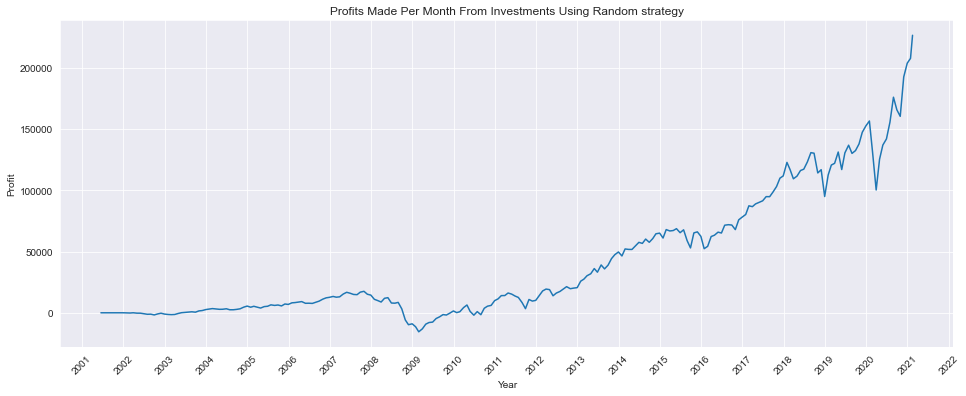

In [13]:
plt.figure(figsize=(16, 6))
g = sns.lineplot(x='Date', y='Profits', data=rand.profits)
plt.xticks([datetime.datetime(year=x, month=1, day=1) for x in range(2001, 2023)], rotation=45)
g.set_xticklabels(list(range(2001, 2023)))
g.set_xlabel('Year')
g.set_ylabel('Profit')
g.set_title('Profits Made Per Month From Investments Using Random strategy');

This shows the money made from dividends

In [14]:
rand.dividends

,Date,Dividend Disbursement,Total Dividends
0,2001-06-25,0.000,0.000
1,2001-09-24,0.000,0.000
2,2001-12-24,0.000,0.000
3,2002-03-25,16.800,16.800
4,2002-06-24,14.560,31.360
...,...,...,...
74,2019-12-24,1442.408,32798.570
75,2020-03-26,999.592,33798.162
76,2020-06-25,1139.600,34937.762
77,2020-09-25,1119.514,36057.276


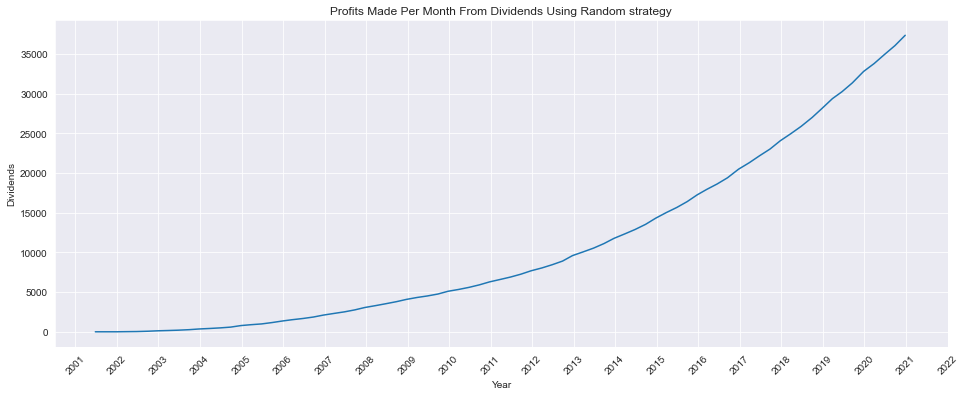

In [15]:
plt.figure(figsize=(16, 6))
g = sns.lineplot(x='Date', y='Total Dividends', data=rand.dividends)
plt.xticks([datetime.datetime(year=x, month=1, day=1) for x in range(2001, 2023)], rotation=45)
g.set_xticklabels(list(range(2001, 2023)))
g.set_xlabel('Year')
g.set_ylabel('Dividends')
g.set_title('Profits Made Per Month From Dividends Using Random strategy');

Here, we overlay the profits made from investments and dividends

In [16]:
rand_merged = rand.profits.merge(rand.dividends, how='outer', on='Date').sort_values('Date').reset_index(drop=True)
rand_merged = rand_merged.fillna(method='pad')
rand_merged['Total Profits'] = rand_merged['Profits'] + rand_merged['Total Dividends']
rand_merged

,Date,Profits,Dividend Disbursement,Total Dividends,Total Profits
0,2001-06-15,0.0000,NaN,NaN,NaN
1,2001-06-25,0.0000,0.000,0.000,0.0000
2,2001-06-29,0.0000,0.000,0.000,0.0000
3,2001-07-31,0.0000,0.000,0.000,0.0000
4,2001-08-31,0.0000,0.000,0.000,0.0000
...,...,...,...,...,...
309,2020-11-30,192587.0753,1119.514,36057.276,228644.3513
310,2020-12-24,192587.0753,1298.902,37356.178,229943.2533
311,2020-12-31,203782.1953,1298.902,37356.178,241138.3733
312,2021-01-29,207746.1853,1298.902,37356.178,245102.3633


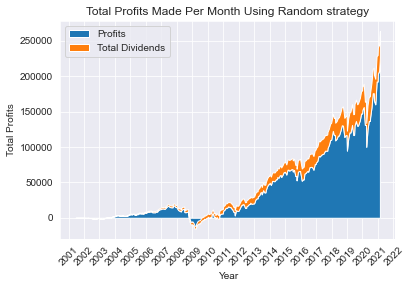

In [17]:
x = rand_merged['Date']
y1 = rand_merged['Profits']
y2 = rand_merged['Total Dividends']

y = np.vstack([y1, y2])

labels = ["Profits", "Total Dividends"]

fig, ax = plt.subplots()
ax.stackplot(x, y, labels=labels)
ax.legend(loc='upper left')
plt.title('Total Profits Made Per Month Using Random strategy')
plt.xticks([datetime.datetime(year=x, month=1, day=1) for x in range(2001, 2023)], rotation=45)
ax.set_xticklabels((list(range(2001, 2023))))
ax.set_xlabel('Year')
ax.set_ylabel('Total Profits')
plt.show()

## Timing the Market (Ideal) Type Investor
This investor uses all their money to buy shares when shares are lowest every year

In [18]:
ideal = Ideal(vti, vti_div)
ideal.execute_strategy(2001, 2021)

This is the leftover uninvested cash by the end of strategy execution

In [19]:
round(ideal.cash, 2)

49.05

This is the investor's portfolio by the end of the strategy execution

In [20]:
ideal.portfolio

,Date,Purchase Price
0,2001-09-21,45.00
1,2001-09-21,45.00
2,2001-09-21,45.00
3,2001-09-21,45.00
4,2001-09-21,45.00
...,...,...
1993,2021-01-05,193.95
1994,2021-01-05,193.95
1995,2021-01-05,193.95
1996,2021-01-05,193.95


This is how much money the investor spent on buying the stocks

In [21]:
ideal.get_invested()

125950.95

This is how much money the investments are worth if we are to sell at the given date

In [22]:
date = '2021-1-04'
ideal.get_value(date)

384410.8

Let's take a look at the profits that are made from this investment strategy.

In [23]:
ideal.profits

,Date,Profits
0,2001-06-15,0.0000
1,2001-06-29,0.0000
2,2001-07-31,0.0000
3,2001-08-31,0.0000
4,2001-09-28,329.1700
...,...,...
233,2020-10-30,211992.7504
234,2020-11-30,250113.2204
235,2020-12-31,263370.7804
236,2021-01-29,268154.5505


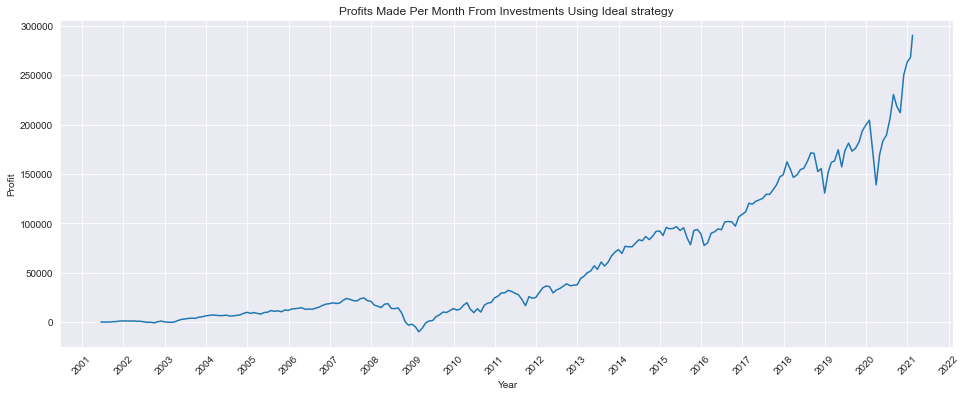

In [24]:
plt.figure(figsize=(16, 6))
g = sns.lineplot(x='Date', y='Profits', data=ideal.profits)
plt.xticks([datetime.datetime(year=x, month=1, day=1) for x in range(2001, 2023)], rotation=45)
g.set_xticklabels(list(range(2001, 2023)))
g.set_xlabel('Year')
g.set_ylabel('Profit')
g.set_title('Profits Made Per Month From Investments Using Ideal strategy');

This shows the money made from dividends

In [25]:
ideal.dividends

,Date,Dividend Disbursement,Total Dividends
0,2001-06-25,0.0000,0.0000
1,2001-09-24,20.9475,20.9475
2,2001-12-24,26.1345,47.0820
3,2002-03-25,19.9500,67.0320
4,2002-06-24,17.2900,84.3220
...,...,...,...
74,2019-12-24,1696.6900,39136.3160
75,2020-03-26,1207.7380,40344.0540
76,2020-06-25,1376.9000,41720.9540
77,2020-09-25,1325.7580,43046.7120


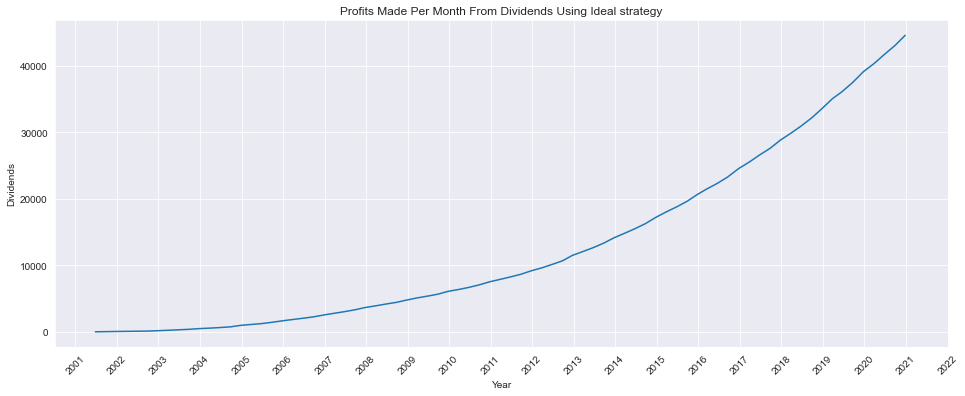

In [26]:
plt.figure(figsize=(16, 6))
g = sns.lineplot(x='Date', y='Total Dividends', data=ideal.dividends)
plt.xticks([datetime.datetime(year=x, month=1, day=1) for x in range(2001, 2023)], rotation=45)
g.set_xticklabels(list(range(2001, 2023)))
g.set_xlabel('Year')
g.set_ylabel('Dividends')
g.set_title('Profits Made Per Month From Dividends Using Ideal strategy');

Here, we overlay the profits made from investments and dividends

In [27]:
ideal_merged = ideal.profits.merge(ideal.dividends, how='outer', on='Date').sort_values('Date').reset_index(drop=True)
ideal_merged = ideal_merged.fillna(method='pad')
ideal_merged['Total Profits'] = ideal_merged['Profits'] + ideal_merged['Total Dividends']
ideal_merged

,Date,Profits,Dividend Disbursement,Total Dividends,Total Profits
0,2001-06-15,0.0000,NaN,NaN,NaN
1,2001-06-25,0.0000,0.000,0.000,0.0000
2,2001-06-29,0.0000,0.000,0.000,0.0000
3,2001-07-31,0.0000,0.000,0.000,0.0000
4,2001-08-31,0.0000,0.000,0.000,0.0000
...,...,...,...,...,...
309,2020-11-30,250113.2204,1325.758,43046.712,293159.9324
310,2020-12-24,250113.2204,1538.194,44584.906,294698.1264
311,2020-12-31,263370.7804,1538.194,44584.906,307955.6864
312,2021-01-29,268154.5505,1538.194,44584.906,312739.4565


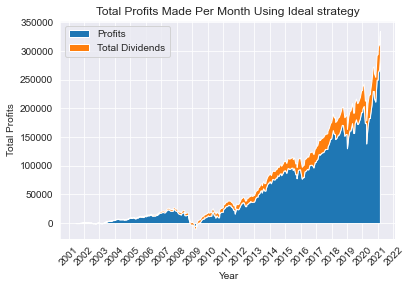

In [28]:
x = ideal_merged['Date']
y1 = ideal_merged['Profits']
y2 = ideal_merged['Total Dividends']

y = np.vstack([y1, y2])

labels = ["Profits", "Total Dividends"]

fig, ax = plt.subplots()
ax.stackplot(x, y, labels=labels)
ax.legend(loc='upper left')
plt.title('Total Profits Made Per Month Using Ideal strategy')
plt.xticks([datetime.datetime(year=x, month=1, day=1) for x in range(2001, 2023)], rotation=45)
ax.set_xticklabels((list(range(2001, 2023))))
ax.set_xlabel('Year')
ax.set_ylabel('Total Profits')
plt.show()

## Take Action (Now) Type Investor
This investor uses all of their money to buy shares at beginning of year

In [29]:
now = Now(vti, vti_div)
now.execute_strategy(2001, 2021)

This is the leftover uninvested cash by the end of strategy execution

In [30]:
round(now.cash, 2)

140.41

This is the investor's portfolio by the end of the strategy execution

In [31]:
now.portfolio

,Date,Purchase Price
0,2001-06-15,56.005
1,2001-06-15,56.005
2,2001-06-15,56.005
3,2001-06-15,56.005
4,2001-06-15,56.005
...,...,...
1713,2021-01-04,195.430
1714,2021-01-04,195.430
1715,2021-01-04,195.430
1716,2021-01-04,195.430


This is how much money the investor spent on buying the stocks

In [32]:
now.get_invested()

125859.59

This is how much money the investments are worth if we are to sell at the given date

In [33]:
date = '2021-1-04'
now.get_value(date)

335748.73

Let's take a look at the profits that are made from this investment strategy.

In [34]:
now.profits

,Date,Profits
0,2001-06-15,0.0049
1,2001-06-29,86.1349
2,2001-07-31,-9.0951
3,2001-08-31,-368.6151
4,2001-09-28,-912.7151
...,...,...
233,2020-10-30,164853.3100
234,2020-11-30,197566.7600
235,2020-12-31,208943.8600
236,2021-01-29,213015.9102


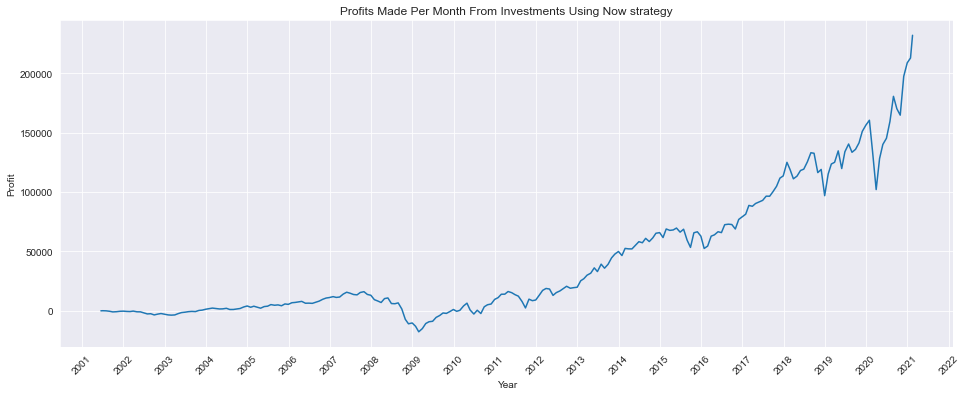

In [35]:
plt.figure(figsize=(16, 6))
g = sns.lineplot(x='Date', y='Profits', data=now.profits)
plt.xticks([datetime.datetime(year=x, month=1, day=1) for x in range(2001, 2023)], rotation=45)
g.set_xticklabels(list(range(2001, 2023)))
g.set_xlabel('Year')
g.set_ylabel('Profit')
g.set_title('Profits Made Per Month From Investments Using Now strategy');

This shows the money made from dividends

In [36]:
now.dividends

,Date,Dividend Disbursement,Total Dividends
0,2001-06-25,14.9800,14.9800
1,2001-09-24,16.8525,31.8325
2,2001-12-24,21.0255,52.8580
3,2002-03-25,32.8500,85.7080
4,2002-06-24,28.4700,114.1780
...,...,...,...
74,2019-12-24,1462.7860,33787.2705
75,2020-03-26,1036.4320,34823.7025
76,2020-06-25,1181.6000,36005.3025
77,2020-09-25,1137.7120,37143.0145


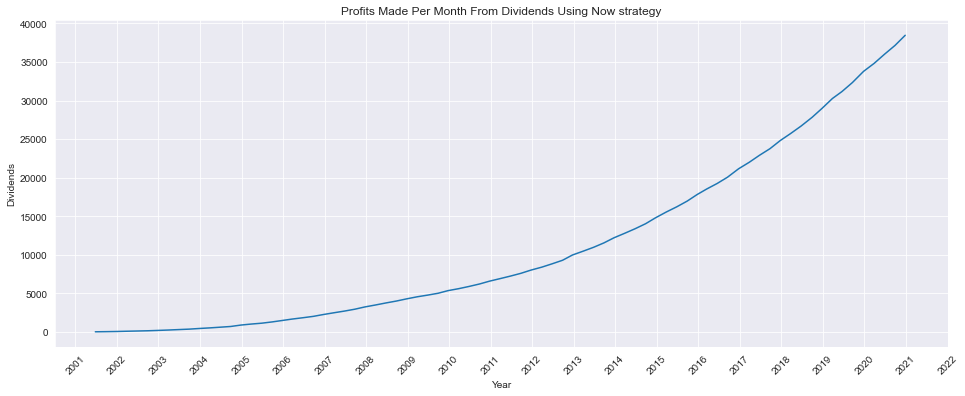

In [37]:
plt.figure(figsize=(16, 6))
g = sns.lineplot(x='Date', y='Total Dividends', data=now.dividends)
plt.xticks([datetime.datetime(year=x, month=1, day=1) for x in range(2001, 2023)], rotation=45)
g.set_xticklabels(list(range(2001, 2023)))
g.set_xlabel('Year')
g.set_ylabel('Dividends')
g.set_title('Profits Made Per Month From Dividends Using Now strategy');

Here, we overlay the profits made from investments and dividends

In [38]:
now_merged = now.profits.merge(now.dividends, how='outer', on='Date').sort_values('Date').reset_index(drop=True)
now_merged = now_merged.fillna(method='pad')
now_merged['Total Profits'] = now_merged['Profits'] + now_merged['Total Dividends']
now_merged

,Date,Profits,Dividend Disbursement,Total Dividends,Total Profits
0,2001-06-15,0.0049,NaN,NaN,NaN
1,2001-06-25,0.0049,14.980,14.9800,14.9849
2,2001-06-29,86.1349,14.980,14.9800,101.1149
3,2001-07-31,-9.0951,14.980,14.9800,5.8849
4,2001-08-31,-368.6151,14.980,14.9800,-353.6351
...,...,...,...,...,...
309,2020-11-30,197566.7600,1137.712,37143.0145,234709.7745
310,2020-12-24,197566.7600,1320.016,38463.0305,236029.7905
311,2020-12-31,208943.8600,1320.016,38463.0305,247406.8905
312,2021-01-29,213015.9102,1320.016,38463.0305,251478.9407


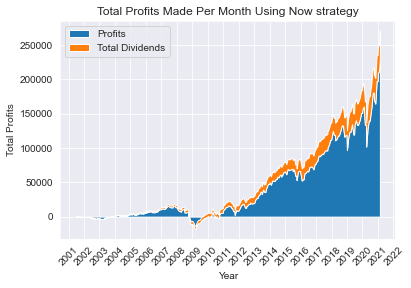

In [39]:
x = now_merged['Date']
y1 = now_merged['Profits']
y2 = now_merged['Total Dividends']

y = np.vstack([y1, y2])

labels = ["Profits", "Total Dividends"]

fig, ax = plt.subplots()
ax.stackplot(x, y, labels=labels)
ax.legend(loc='upper left')
plt.title('Total Profits Made Per Month Using Now strategy')
plt.xticks([datetime.datetime(year=x, month=1, day=1) for x in range(2001, 2023)], rotation=45)
ax.set_xticklabels((list(range(2001, 2023))))
ax.set_xlabel('Year')
ax.set_ylabel('Total Profits')
plt.show()

## Dollar Cost Averaging (Average) Type Investor
Not to be confused with "the average, everyday investor", this investor portions out their money over year and buys shares at beginning of each month (Dollar Cost Averaging)

In [40]:
avg = Average(vti, vti_div)
avg.execute_strategy(2001, 2021)

This is the leftover uninvested cash by the end of strategy execution

In [41]:
round(avg.cash, 2)

146.75

This is the investor's portfolio by the end of the strategy execution

In [42]:
avg.portfolio

,Date,Purchase Price
0,2001-06-15,56.005
1,2001-06-15,56.005
2,2001-06-15,56.005
3,2001-06-15,56.005
4,2001-06-15,56.005
...,...,...
1694,2021-02-16,208.390
1695,2021-02-16,208.390
1696,2021-02-16,208.390
1697,2021-02-16,208.390


This is how much money the investor spent on buying the stocks

In [43]:
avg.get_invested()

125853.25

This is how much money the investments are worth if we are to sell at the given date

In [44]:
avg.get_value()

354054.61

Let's take a look at the profits that are made from this investment strategy.

In [45]:
avg.profits

,Date,Profits
0,2001-06-15,0.0049
1,2001-06-29,42.6649
2,2001-07-31,-13.9551
3,2001-08-31,-252.9651
4,2001-09-28,-664.0401
...,...,...
233,2020-10-30,161987.6399
234,2020-11-30,194310.3099
235,2020-12-31,205562.7499
236,2021-01-29,209542.8199


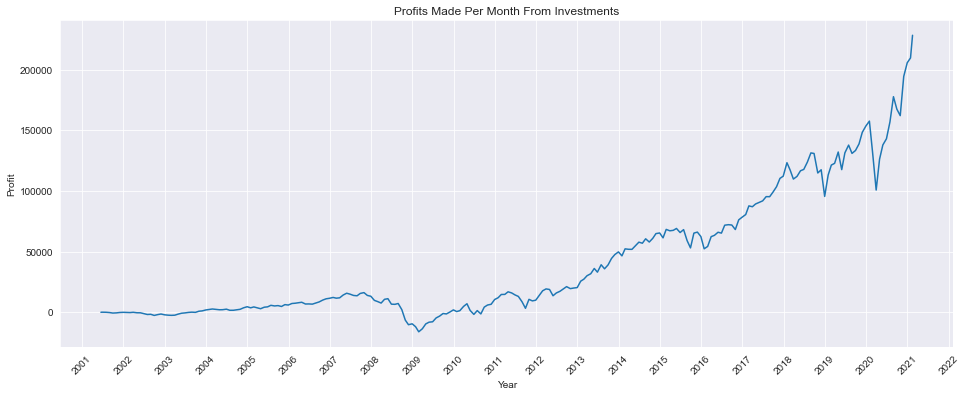

In [46]:
plt.figure(figsize=(16, 6))
g = sns.lineplot(x='Date', y='Profits', data=avg.profits)
plt.xticks([datetime.datetime(year=x, month=1, day=1) for x in range(2001, 2023)], rotation=45)
g.set_xticklabels(list(range(2001, 2023)))
g.set_xlabel('Year')
g.set_ylabel('Profit')
g.set_title('Profits Made Per Month From Investments');

This shows the money made from dividends

In [47]:
avg.dividends

,Date,Dividend Disbursement,Total Dividends
0,2001-06-25,7.4200,7.4200
1,2001-09-24,12.6000,20.0200
2,2001-12-24,21.8115,41.8315
3,2002-03-25,20.8500,62.6815
4,2002-06-24,21.8400,84.5215
...,...,...,...
74,2019-12-24,1446.8380,33052.3820
75,2020-03-26,1008.1880,34060.5700
76,2020-06-25,1157.1000,35217.6700
77,2020-09-25,1120.1880,36337.8580


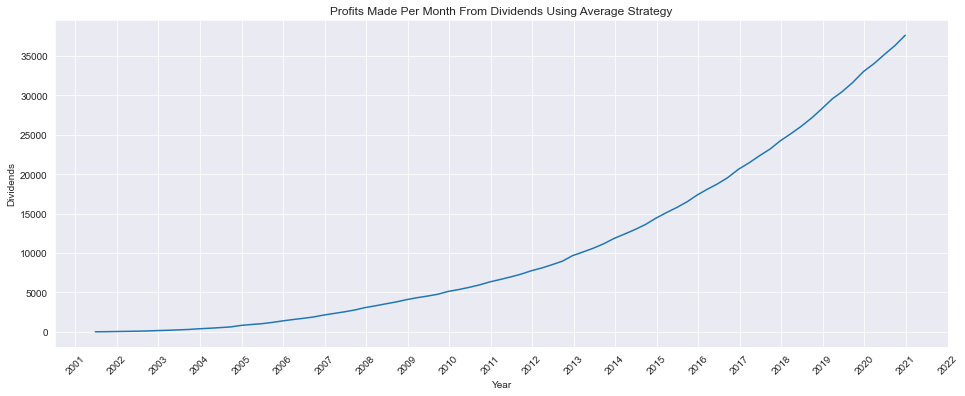

In [48]:
plt.figure(figsize=(16, 6))
g = sns.lineplot(x='Date', y='Total Dividends', data=avg.dividends)
plt.xticks([datetime.datetime(year=x, month=1, day=1) for x in range(2001, 2023)], rotation=45)
g.set_xticklabels(list(range(2001, 2023)))
g.set_xlabel('Year')
g.set_ylabel('Dividends')
g.set_title('Profits Made Per Month From Dividends Using Average Strategy');

Here, we overlay the profits made from investments and dividends

In [49]:
avg_merged = avg.profits.merge(avg.dividends, how='outer', on='Date').sort_values('Date').reset_index(drop=True)
avg_merged = avg_merged.fillna(method='pad')
avg_merged['Total Profits'] = avg_merged['Profits'] + avg_merged['Total Dividends']
avg_merged

,Date,Profits,Dividend Disbursement,Total Dividends,Total Profits
0,2001-06-15,0.0049,NaN,NaN,NaN
1,2001-06-25,0.0049,7.420,7.420,7.4249
2,2001-06-29,42.6649,7.420,7.420,50.0849
3,2001-07-31,-13.9551,7.420,7.420,-6.5351
4,2001-08-31,-252.9651,7.420,7.420,-245.5451
...,...,...,...,...,...
309,2020-11-30,194310.3099,1120.188,36337.858,230648.1679
310,2020-12-24,194310.3099,1305.940,37643.798,231954.1079
311,2020-12-31,205562.7499,1305.940,37643.798,243206.5479
312,2021-01-29,209542.8199,1305.940,37643.798,247186.6179


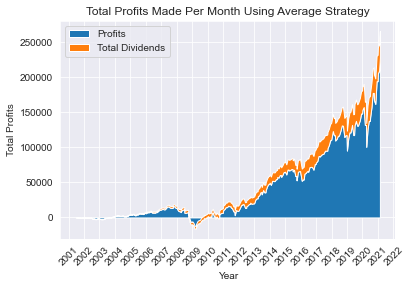

In [50]:
x = avg_merged['Date']
y1 = avg_merged['Profits']
y2 = avg_merged['Total Dividends']

y = np.vstack([y1, y2])

labels = ["Profits", "Total Dividends"]

fig, ax = plt.subplots()
ax.stackplot(x, y, labels=labels)
ax.legend(loc='upper left')
plt.title('Total Profits Made Per Month Using Average Strategy')
plt.xticks([datetime.datetime(year=x, month=1, day=1) for x in range(2001, 2023)], rotation=45)
ax.set_xticklabels((list(range(2001, 2023))))
ax.set_xlabel('Year')
ax.set_ylabel('Total Profits')
plt.show()

# Putting it all together

Now that we've seen all of these strategies run separately, let's take a look at them side-by-side.

In [51]:
g_now = now_merged[['Date', 'Total Profits']]
g_avg = avg_merged[['Date', 'Total Profits']]
g_ideal = ideal_merged[['Date', 'Total Profits']]
g_rand = rand_merged[['Date', 'Total Profits']]

g_now['Strategy'] = 'Now'
g_avg['Strategy'] = 'Average'
g_ideal['Strategy'] = 'Ideal'
g_rand['Strategy'] = 'Random'

# Combining all the different strategies into one DataFrame
g_all = pd.concat([g_now, g_avg, g_rand, g_ideal]).sort_values('Date').reset_index(drop=True)

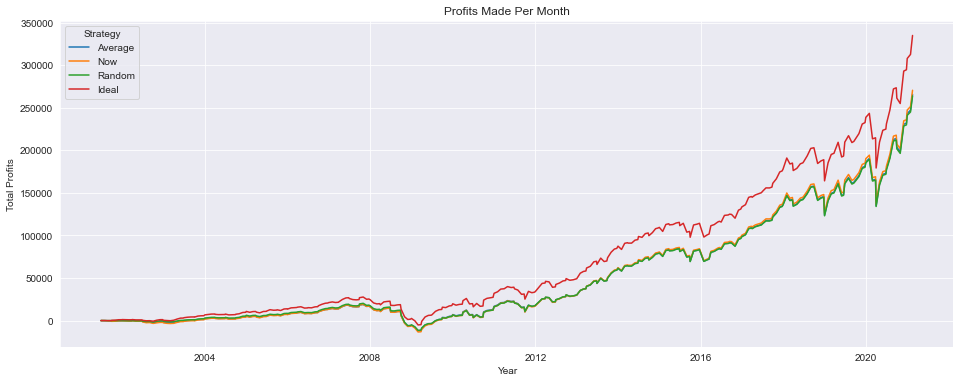

In [52]:
plt.figure(figsize=(16, 6))
g = sns.lineplot(data=g_all, x='Date', y='Total Profits', hue='Strategy', hue_order=['Average', 'Now', 'Random', 'Ideal'])
g.set_xlabel('Year')
g.set_ylabel('Total Profits')
g.set_title('Profits Made Per Month');

Since the Ideal investor is higher than the others, we can't see how the other strategies are doing. Obviously, the Ideal strategy will lead to a much higher profit, but it is not plausible to say that someone can be an ideal investor, unless they can predict the future. Let's remove it from the graphic so we can get a better look at what is happening among the other three strategies.

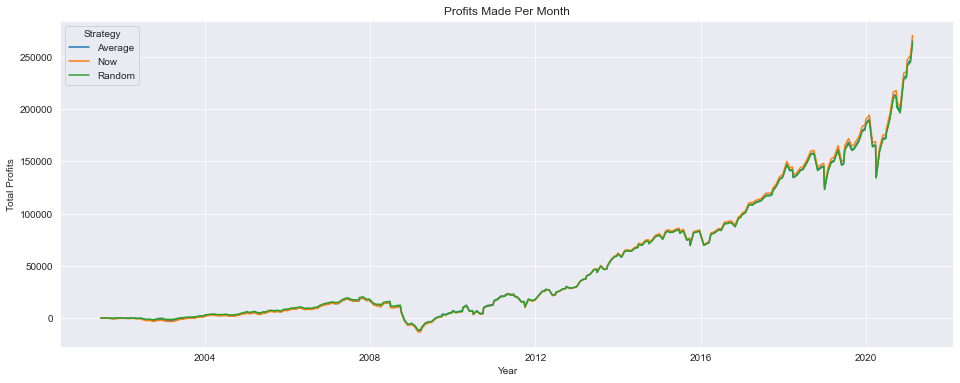

In [53]:
g_no_ideal = g_all[g_all['Strategy'] != 'Ideal']
plt.figure(figsize=(16, 6))
g = sns.lineplot(data=g_no_ideal, x='Date', y='Total Profits', hue='Strategy', hue_order=['Average', 'Now', 'Random'])
g.set_xlabel('Year')
g.set_ylabel('Total Profits')
g.set_title('Profits Made Per Month');

We can see from this graph that there is no huge difference in profits from the three investment strategies: Average, Now, and Random.

We've seen the investment strategies compete against one another over time, but let's take a closer look at the differences at the end of the strategy execution.

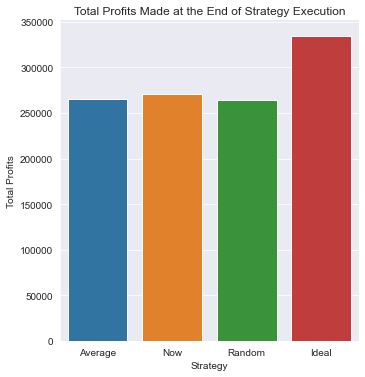

In [54]:
date = g_all['Date'][len(g_all)-1]
g = sns.catplot(x='Strategy', y='Total Profits', data=g_all[g_all['Date'] == date], kind='bar')
plt.title('Total Profits Made at the End of Strategy Execution');

And here's the graph again without the Ideal investor.

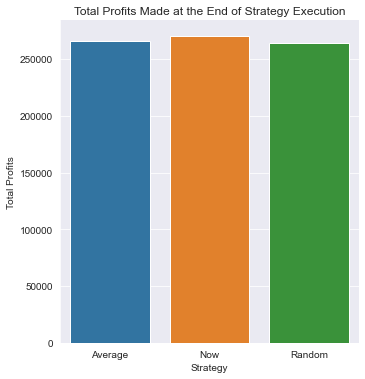

In [55]:
g = sns.catplot(x='Strategy', y='Total Profits', data=g_no_ideal[g_no_ideal['Date'] == date], kind='bar')
plt.title('Total Profits Made at the End of Strategy Execution');

By the end of strategy execution (January 2021), the Now strategy comes out on top, the Average strategy coming in second, and the Random strategy coming in third.

## Ranking Strategies by Total Profit for Each Year

In [56]:
# Look at data for first month of each year
yearly = g_all[(g_all['Date'].dt.month == 1)]

# Assign ranks to highest total profits for each year
yearly['Rank'] = yearly.groupby('Date').rank(ascending=False)
yearly['Rank'] = yearly['Rank'].apply(lambda x: int(x))

In [57]:
rank = pd.pivot_table(yearly, values='Rank', index=['Date'], columns=['Strategy'])[['Ideal', 'Average', 'Now', 'Random']]
rank

Strategy,Ideal,Average,Now,Random
Date,,,,
2002-01-31,1,3,4,2
2003-01-31,1,3,4,2
2004-01-30,1,3,4,2
2005-01-31,1,3,4,2
2006-01-31,1,3,4,2
2007-01-31,1,3,4,2
2008-01-31,1,3,4,2
2009-01-30,1,3,4,2
2010-01-29,1,2,4,3


In [58]:
rank.describe()

Strategy,Ideal,Average,Now,Random
count,20.0,20.000000,20.000000,20.000000
mean,1.0,2.950000,3.100000,2.950000
std,0.0,0.394034,0.967906,0.998683
min,1.0,2.000000,2.000000,2.000000
25%,1.0,3.000000,2.000000,2.000000
50%,1.0,3.000000,3.500000,2.500000
75%,1.0,3.000000,4.000000,4.000000
max,1.0,4.000000,4.000000,4.000000


In this data, we can look at the mean see that the Ideal investor is Rank 1 at the beginning of every year, every time.  The Average investor has a mean of Rank 2.55, Now investor having a mean of Rank 2.95, and Random investor coming in last with a mean of Rank 3.5.

With this, it is obvious that everyone should go for the Ideal investor strategy and everyone should avoid the random strategy.

Keep in mind that although the Average investor has a higher rank than the Now investor, it does not necessarily mean that the Average investment strategy is better. Taking a closer look at the rank DataFrame, the Average investor holds a consistent Rank 2 for the first decade, but eventually falls to Rank 3, losing to the Now investor in the second decade.

# Conclusion

We have taken a look at four investment strategies: Random, Ideal, Now, and Average. From the barplot, we saw that at the end of strategy execution (January 2021), the Ideal investor came in first with a much higher profit than the three other investment strategies. Since it is almost impossible to predict the status of the stock market, the Ideal investment strategy should only be seen as a mode of comparison for the other three investment strategies. It was seen that among the three strategies, there is **little difference in profits.** If we want to care about the little differences, we saw that the Average investor has more years where it has more profits than the Now investor. In the long run, the Now investor surpasses the Average and Random investment strategies and comes out on top.

With this, we can conclude that, aside from the Ideal investment strategy, the **Average** and **Now** investment strategies are equally more superior investment strategies, doing better than our base scenario of the Random investment strategy.

If I were to recommend a strategy to a friend, I would say to go with the Now investment strategy if they have the money to do so. It takes less work to execute since they can just put the money in and forget about it. I personally believe that the minimal profit difference between the Now and Average investment strategies are not worth the extra work. If they don't have a huge amount of money to invest at the beginning of the year, then it is fine to go with the Average investment strategy.

***Disclaimer***: I am not a financial advisor and am only making conclusions from real stock market data run on my simulations.

# Unit Tests

In [59]:
vti = pd.read_csv('test/VTI.csv').sort_values('Date').reset_index(drop=True)
vti_div = pd.read_csv('test/VTI_Dividends.csv').sort_values('Date').reset_index(drop=True)
standardize_date = lambda string: datetime.datetime.strptime(string, '%Y-%m-%d')
vti['Date'] = vti['Date'].apply(standardize_date)
vti_div['Date'] = vti_div['Date'].apply(standardize_date)

In [60]:
test = Investor(vti, vti_div)
assert test.cash == 0
test.income()
assert test.cash == test.salary

In [61]:
assert test.create_date('2001-05-31') == datetime.datetime(year=2001, month=5, day=31)

In [62]:
# Test before first forward
test_row, test_date = test.get_nearest_date('2001-06-13')
assert test_date == test.create_date('2001-06-15')
# Test after last forward
test_row, test_date = test.get_nearest_date('2021-02-17')
assert test_date == test.create_date('2021-02-16')
# Test before first reverse
test_row, test_date = test.get_nearest_date('2001-06-13', True)
assert test_date == test.create_date('2001-06-15')
# Test after last reverse
test_row, test_date = test.get_nearest_date('2021-02-17', True)
assert test_date == test.create_date('2021-02-16')
# Test forward
test_row, test_date = test.get_nearest_date('2021-02-13')
assert test_date == test.create_date('2021-02-16')
# Test reverse
test_row, test_date = test.get_nearest_date('2001-06-17', True)
assert test_date == test.create_date('2001-06-15')

In [63]:
assert test.get_stock_price('2001-06-15') == 56.005001
assert test.get_stock_price('2001-06-14') == 56.005001
assert test.get_stock_price('2001-06-17') == 55.915001

In [64]:
# Not enough money
test.cash = 0
assert not test.buy_stock('2001-06-15')
# Enough money
test.cash = 200
assert test.buy_stock('2001-06-15')

In [65]:
test = Investor(vti, vti_div)
test.cash = 9999999
for i in range(100):
    test.buy_stock('2001-06-15')
    test.buy_stock('2021-02-16')

# All
np.testing.assert_almost_equal(test.get_invested(), 56.005001*100 + 208.389999*100)
# Before specific date
np.testing.assert_almost_equal(test.get_invested('2002-01-01'), 56.005001*100)

In [66]:
test = Investor(vti, vti_div)
test.cash = 9999999
for i in range(100):
    test.buy_stock('2001-06-15')
    test.buy_stock('2021-02-16')

# All
np.testing.assert_almost_equal(test.get_value(), 200*208.39)
# Before specific date
np.testing.assert_almost_equal(test.get_value('2001-06-21'), 56.725*100)

In [67]:
test = Investor(vti, vti_div)
test.cash = 9999999
for i in range(100):
    test.buy_stock('2001-06-15')

test.find_profits(2001)
np.testing.assert_almost_equal(test.profits[test.profits['Date'] == '2001-06-15']['Profits'].values[0], 0, decimal=3)

np.testing.assert_almost_equal(test.profits[test.profits['Date'] == '2001-06-29']['Profits'].values[0], (56.81-56.005)*100, decimal=3)

In [68]:
# 10 stocks same date

test = Investor(vti, vti_div)
test.cash = 999999

for i in range(10):
    test.buy_stock('2001-06-15')
test.find_dividends()

assert test.dividends['Dividend Disbursement'][0] == 10*vti_div['Dividends'][0]
assert test.dividends['Dividend Disbursement'][1] == 10*vti_div['Dividends'][1]
assert test.dividends['Total Dividends'][1] == test.dividends['Dividend Disbursement'][0] + test.dividends['Dividend Disbursement'][1]
assert test.dividends['Dividend Disbursement'][len(test.dividends)-1] == 10*vti_div['Dividends'][len(vti_div)-1]

In [69]:
# 10 stocks each different dates
test = Investor(vti, vti_div)
test.cash = 999999

for i in range(10):
    test.buy_stock('2001-06-15')
    test.buy_stock('2001-09-21')
test.find_dividends()
test.dividends

assert test.dividends['Dividend Disbursement'][0] == 10*vti_div['Dividends'][0]
assert test.dividends['Dividend Disbursement'][1] == 20*vti_div['Dividends'][1]
assert test.dividends['Total Dividends'][1] == test.dividends['Dividend Disbursement'][0] + test.dividends['Dividend Disbursement'][1]
assert test.dividends['Dividend Disbursement'][len(test.dividends)-1] == 20*vti_div['Dividends'][len(vti_div)-1]